In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import anndata as ad 
import scanpy as sc
sys.path.append("../../../../spatial-clust-scripts-main/")
import utils
from sklearn.decomposition import PCA
import umap
import graph
import visualize
import sklearn.metrics

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#### read in 4 cellsnap embeddings
snap_embed1 = np.load("../../data/saved_embedding/nbhd_k256_dbGNN_0327.npy")
snap_embed2 = np.load("../../data/saved_embedding/nbhd_k512_dbGNN_0327.npy")
snap_embed3 = np.load("../../data/saved_embedding/nbhd_k1024_dbGNN_0327.npy")

print([snap_embed1.shape, snap_embed2.shape, snap_embed3.shape])

[(53500, 32), (53500, 32), (53500, 32)]


In [3]:
# for loop start:
batch = 5
dflist = []
for i in range(batch):
    print('at', i)
    
    indices = np.random.choice(snap_embed1.shape[0], 10000, replace=False)
    
    snap_embed_sub1 = snap_embed1[indices]
    snap_embed_sub2 = snap_embed2[indices]
    snap_embed_sub3 = snap_embed3[indices]
    
    ##### calculate umap
    
    # start to calculate silhoutte score
    cond1_list = []
    cond2_list = []
    cond3_list = []

    k_clusters = [x for x in range(5,30,2)]

    for k in k_clusters:

        ## snap1
        snap_edges1 = graph.get_feature_edges(
            arr=snap_embed_sub1, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        snap_labels1 = graph.graph_clustering(
            snap_embed_sub1.shape[0], snap_edges1, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )
        ## snap2
        snap_edges2 = graph.get_feature_edges(
            arr=snap_embed_sub2, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        snap_labels2 = graph.graph_clustering(
            snap_embed_sub2.shape[0], snap_edges2, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )
        ## snap3
        snap_edges3 = graph.get_feature_edges(
            arr=snap_embed_sub3, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
        )
        snap_labels3 = graph.graph_clustering(
            snap_embed_sub3.shape[0], snap_edges3, resolution=None, n_clusters=k, n_runs=1,
            resolution_tol=0.05, seed=None, verbose=False
        )
        
        snap_ss1 = sklearn.metrics.davies_bouldin_score(snap_embed_sub1, snap_labels1)
        snap_ss2 = sklearn.metrics.davies_bouldin_score(snap_embed_sub2, snap_labels2)
        snap_ss3 = sklearn.metrics.davies_bouldin_score(snap_embed_sub3, snap_labels3)

        cond1_list.append(snap_ss1)
        cond2_list.append(snap_ss2)
        cond3_list.append(snap_ss3)
        
    data = {'k':k_clusters, '256':cond1_list,
            '512':cond2_list,'1024':cond3_list}
    
    df = pd.DataFrame(data)
    df['batch'] = i
    dflist.append(df)
    


at 0
at 1
at 2
at 3
at 4


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


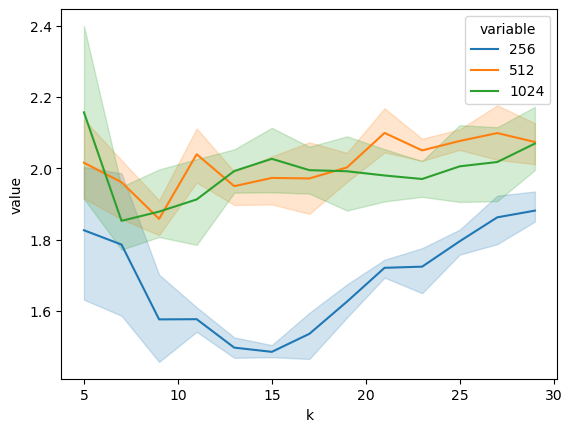

In [4]:
test = pd.concat(dflist)
test2 = test.melt(id_vars=['k'], value_vars=['256', '512', '1024'])
test2.to_csv('../../data/metrics/DB_imgsize_0327.csv')

plot = sns.lineplot(data=test2,x="k", y="value", hue="variable")
fig = plot.get_figure()
fig.savefig('../../plots/DB_imgsize_0327.svg', dpi = 300) 